# Prepare

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact, mannwhitneyu
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper", 1.4,
                rc={"lines.linewidth": 1})
sns.set_style("ticks",
              rc={"text.color"       : "black",
                  "axes.edgecolor"   : "black",
                  "axes.labelcolor"  : "black",
                  "xtick.color"      : "black",
                  "ytick.color"      : "black",
                  "axes.grid"        : False,
                  "axes.spines.right": False,
                  "axes.spines.top"  : False})
sns.set_palette(["#134f85", "#dba11c", "#6f7788"])

figsize = (16,2)
bbox_to_anchor=(0.5, -0.3)

annot_size=12
flierprops = dict(marker=".", markeredgecolor="black", markerfacecolor="black")
boxprops = dict(edgecolor="black")
medianprops = dict(color="black")
whiskerprops = dict(color="black")
capprops = dict(color="black")

## Read Data

In [2]:
error = pd.read_csv("error.csv")
anytime = pd.read_csv("anytime.csv")
stat = error.groupby(["Problem", "Method", "Period"], as_index=False).sum()
stat = stat[stat.Period=="Test"][["Problem","Method","Success Rate"]]

# Experiment I

## Train error in 25 runs

- The value on a line segment is the p-value of **Wilcoxon rank sum test** between two groups.
- The p-value is marked with an asterisk if the difference between two groups is significant (p<0.05).

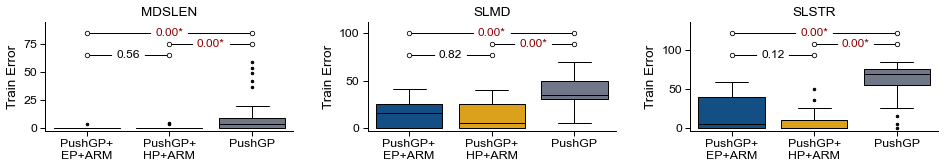

In [3]:
probs = ["MDSLEN", "SLMD", "SLSTR"]
methods = ["PushGP+EP+ARM","PushGP+HP+ARM", "PushGP"]

fig, axs = plt.subplots(1, 3, figsize=figsize)
plt.subplots_adjust(wspace=0.3)
k = 0
for ax, prob in zip(axs, probs):
    k += 1
    error_ = error[(error.Problem==prob) & (error.Period=="Train")]
    ax.set_title(prob)
    b = sns.boxplot(data=error_, x="Method", y="Error",
                    order=methods,
                    flierprops=flierprops, boxprops=boxprops,
                    medianprops=medianprops,
                    whiskerprops=whiskerprops, capprops=capprops,
                    saturation=1.,
                    ax=ax)
    h_min, h_max = ax.get_ylim()
    h_total = h_max - h_min
    h_max_ = h_min + h_total*1.5
    ax.set_ylim(h_min, h_max_)
    for i in range(3):
        j = (i+1)%3
        h = h_max+h_total*0.05+i*h_total*0.15
        ax.hlines(y=h, xmin=i, xmax=j, color="black", zorder=3+3-i)
        ax.scatter(x=i, y=h, s=20, color="w", edgecolors="black", zorder=3+3-i)
        ax.scatter(x=j, y=h, s=20, color="w", edgecolors="black", zorder=3+3-i)
        dat1 = error_[error_.Method==methods[i]]["Error"].values
        dat2 = error_[error_.Method==methods[j]]["Error"].values
        _, p = mannwhitneyu(dat1, dat2)
        alpha = 0.05
        alpha = 1 - (1-alpha)**(1/9)
        s = f"{p:.2f}*" if p<alpha else f"{p:.2f}"
        c = "darkred" if p<alpha else "black"
        ax.text((i+j)/2, h, s, color=c, fontsize=annot_size, ha="center", va="center", backgroundcolor="white", zorder=3+3-i)
    ax.set_xlabel("")
    ax.set_ylabel("Train Error")
    ax.set_xticklabels(["PushGP+\nEP+ARM","PushGP+\nHP+ARM", "PushGP"])
    ax.legend([],[],frameon=False)
plt.savefig(f"figure/train.eps", bbox_inches="tight")
plt.savefig(f"figure/train.png", bbox_inches="tight", dpi=300)

## Test success count in 25 runs

- The number above a bar is the success count.
- The value on a line segment is the p-value of **Fisher’s exact test** between two groups.
- The p-value is marked with an asterisk if the difference between two groups is significant (p<0.05).

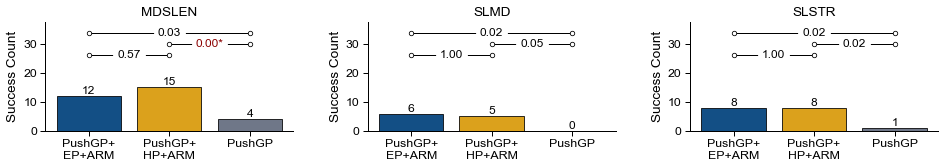

In [4]:
probs = ["MDSLEN", "SLMD", "SLSTR"]
methods = ["PushGP+EP+ARM","PushGP+HP+ARM", "PushGP"]

fig, axs = plt.subplots(1, 3, figsize=figsize)
plt.subplots_adjust(wspace=0.3)
k = 0
for ax, prob in zip(axs, probs):
    k += 1
    error_ = error[(error.Problem==prob) & (error.Period=="Test")]
    ax.set_title(prob)
    b = sns.barplot(data=error_, x="Method", y="Success Rate", estimator=sum,
                    order=methods,
                    edgecolor="black",
                    saturation=1.,
                    errcolor="none", ax=ax)
    for container in b.containers:
        b.bar_label(container, fontsize=annot_size)
    ax.set_ylim(0, 25)
    h_min, h_max = ax.get_ylim()
    h_total = h_max - h_min
    h_max_ = h_min + h_total*1.5
    ax.set_ylim(h_min, h_max_)
    stat_ = stat[stat.Problem==prob]
    for i in range(3):
        j = (i+1)%3
        h = h_max+h_total*0.05+i*h_total*0.15
        ax.hlines(y=h, xmin=i, xmax=j, color="black", zorder=3+3-i)
        ax.scatter(x=i, y=h, s=20, color="w", edgecolors="black", zorder=3+3-i)
        ax.scatter(x=j, y=h, s=20, color="w", edgecolors="black", zorder=3+3-i)
        dat1 = stat_[stat_.Method==methods[i]]["Success Rate"].item()
        dat2 = stat_[stat_.Method==methods[j]]["Success Rate"].item()
        x = [[dat1, dat2], [25-dat1, 25-dat2]]
        _, p = fisher_exact(x)
        alpha = 0.05
        alpha = 1 - (1-alpha)**(1/9)
        s = f"{p:.2f}*" if p<alpha else f"{p:.2f}"
        c = "darkred" if p<alpha else "black"
        ax.text((i+j)/2, h, s, color=c, fontsize=annot_size, ha="center", va="center", backgroundcolor="white", zorder=3+3-i)
    ax.set_xlabel("")
    ax.set_ylabel("Success Count")
    ax.set_xticklabels(["PushGP+\nEP+ARM","PushGP+\nHP+ARM", "PushGP"])
    ax.legend([],[],frameon=False)
plt.savefig(f"figure/count.eps", bbox_inches="tight")
plt.savefig(f"figure/count.png", bbox_inches="tight", dpi=300)

## Best train error in the population by generations (avg. of 25 runs）

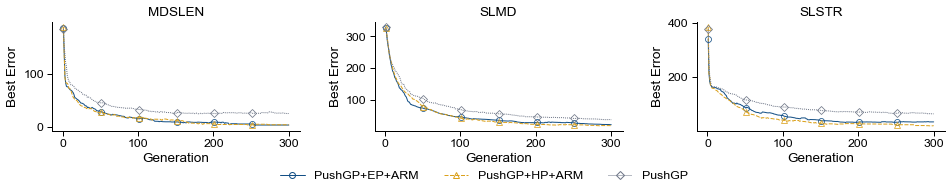

In [5]:
markers = ["o","^","D"]
fig, axs = plt.subplots(1, 3, figsize=figsize)
plt.subplots_adjust(wspace=0.3)
k = 0
for ax, prob in zip(axs, probs):
    k += 1
    anytime_ = anytime[(anytime.Problem==prob) & (anytime.Method.isin(methods))]
    sns.lineplot(data=anytime_, x="Generation", y="Best Error",
                 hue="Method", hue_order=methods,
                 style="Method", style_order=methods,
                 markers=markers[:3], markevery=50, markersize=6,
                 markerfacecolor="none", markeredgecolor=None,
                 ci=None, ax=ax)
    ax.set_title(prob)
    leg = ax.legend(edgecolor="black", shadow=True)
    ax.legend([],[],frameon=False)
ls = leg.get_lines()
for line in ls:
    line.set_markersize(6)
    line.set_markeredgecolor(None)
    line.set_markerfacecolor("none")
fig.legend(ls,
           methods,
           frameon=False,
           loc="lower center", bbox_to_anchor=bbox_to_anchor,
           ncol=3)
plt.savefig(f"figure/error.eps", bbox_inches="tight")
plt.savefig(f"figure/error.png", bbox_inches="tight", dpi=300)

# Experiment II

## Train error in 25 runs

- The value on a line segment is the p-value of **Wilcoxon rank sum test** between two groups.
- The p-value is marked with an asterisk if the difference between two groups is significant (p<0.05).

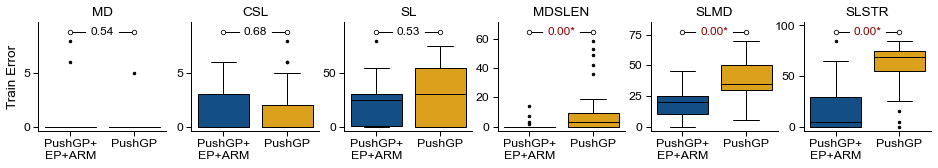

In [6]:
probs_set = [["MD", "CSL", "SL", "MDSLEN", "SLMD", "SLSTR"]]
methods = ["KDPS", "PushGP"]

for idx, probs in enumerate(probs_set):
    fig, axs = plt.subplots(1, 6, figsize=figsize)
    plt.subplots_adjust(wspace=0.2)
    k = 0
    for ax, prob in zip(axs, probs):
        k += 1
        error_ = error[(error.Problem==prob) & (error.Period=="Train")]
        ax.set_title(prob)
        b = sns.boxplot(data=error_, x="Method", y="Error",
                        order=methods,
                        flierprops=flierprops, boxprops=boxprops,
                        medianprops=medianprops,
                        whiskerprops=whiskerprops, capprops=capprops,
                        saturation=1.,
                        ax=ax)
        h_min, h_max = ax.get_ylim()
        h_total = h_max - h_min
        h_max_ = h_min + h_total*1.15
        ax.set_ylim(h_min, h_max_)
        for i in range(1):
            j = (i+1)%2
            h = h_max+h_total*0.05+i*h_total*0.1
            ax.hlines(y=h, xmin=i, xmax=j, color="black")
            ax.scatter(x=i, y=h, s=20, color="w", edgecolors="black", zorder=2)
            ax.scatter(x=j, y=h, s=20, color="w", edgecolors="black", zorder=2)
            dat1 = error_[error_.Method==methods[i]]["Error"].values
            dat2 = error_[error_.Method==methods[j]]["Error"].values
            _, p = mannwhitneyu(dat1, dat2)
            alpha = 0.05
            alpha = 1 - (1-alpha)**(1/6)
            s = f"{p:.2f}*" if p<alpha else f"{p:.2f}"
            c = "darkred" if p<alpha else "black"
            ax.text((i+j)/2, h, s, color=c, fontsize=annot_size, ha="center", va="center", backgroundcolor="white", zorder=3+3-i)
        ax.set_xlabel("")
        ax.set_ylabel("Train Error")
        if k>1:
            ax.set_ylabel("")
        ax.set_xticklabels(["PushGP+\nEP+ARM", "PushGP"])
        ax.legend([],[],frameon=False)
    plt.savefig(f"figure/train2{idx}.eps", bbox_inches="tight")
    plt.savefig(f"figure/train2{idx}.png", bbox_inches="tight", dpi=300)

## Test success count in 25 runs

- The number above a bar is the success count.
- The value on a line segment is the p-value of **Fisher’s exact test** between two groups.
- The p-value is marked with an asterisk if the difference between two groups is significant (p<0.05).

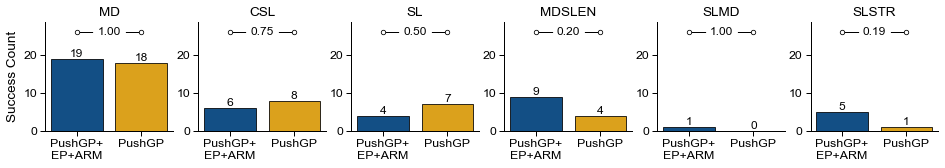

In [7]:
probs_set = [["MD", "CSL", "SL", "MDSLEN", "SLMD", "SLSTR"]]
methods = ["KDPS", "PushGP"]

for idx, probs in enumerate(probs_set):
    fig, axs = plt.subplots(1, 6, figsize=figsize)
    plt.subplots_adjust(wspace=0.2)
    k = 0
    for ax, prob in zip(axs, probs):
        k += 1
        error_ = error[(error.Problem==prob) & (error.Period=="Test")]
        ax.set_title(prob)
        b = sns.barplot(data=error_, x="Method", y="Success Rate", estimator=sum,
                        order=methods,
                        edgecolor="black",
                        saturation=1.,
                        errcolor="none", ax=ax)
        for container in b.containers:
            b.bar_label(container, fontsize=annot_size)

        stat_ = stat[stat.Problem==prob]
        ax.set_ylim(0, 25)
        h_min, h_max = ax.get_ylim()
        h_total = h_max - h_min
        h_max_ = h_min + h_total*1.15
        ax.set_ylim(h_min, h_max_)
        stat_ = stat[stat.Problem==prob]
        for i in range(1):
            j = (i+1)%2
            h = h_max+h_total*0.05+i*h_total*0.1
            ax.hlines(y=h, xmin=i, xmax=j, color="black")
            ax.scatter(x=i, y=h, s=20, color="w", edgecolors="black", zorder=2)
            ax.scatter(x=j, y=h, s=20, color="w", edgecolors="black", zorder=2)
            try:
                dat1 = stat_[stat_.Method==methods[i]]["Success Rate"].item()
            except Exception:
                dat1 = 0
            try:
                dat2 = stat_[stat_.Method==methods[j]]["Success Rate"].item()
            except Exception:
                dat2 = 0
            x = [[dat1, dat2], [25-dat1, 25-dat2]]
            _, p = fisher_exact(x)
            alpha = 0.05
            alpha = 1 - (1-alpha)**(1/6)
            s = f"{p:.2f}*" if p<alpha else f"{p:.2f}"
            c = "darkred" if p<alpha else "black"
            ax.text((i+j)/2, h, s, color=c, fontsize=annot_size, ha="center", va="center", backgroundcolor="white", zorder=3+3-i)
        ax.set_xlabel("")
        ax.set_ylabel("Success Count")
        if k>1:
            ax.set_ylabel("")
        ax.set_xticklabels(["PushGP+\nEP+ARM", "PushGP"])
        ax.legend([],[],frameon=False)
    plt.savefig(f"figure/count2{idx}.eps", bbox_inches="tight")
    plt.savefig(f"figure/count2{idx}.png", bbox_inches="tight", dpi=300)

## Best train error in the population by generations (avg. of 25 runs）

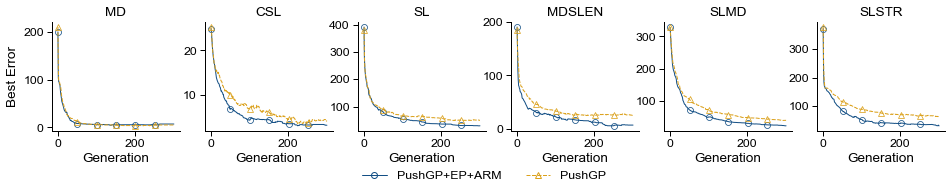

In [8]:
markers = ["o","^","D"]
for idx, probs in enumerate(probs_set):
    fig, axs = plt.subplots(1, 6, figsize=figsize)
    plt.subplots_adjust(wspace=0.2)
    k = 0
    for ax, prob in zip(axs, probs):
        k += 1
        anytime_ = anytime[(anytime.Problem==prob) & (anytime.Method.isin(methods))]
        sns.lineplot(data=anytime_, x="Generation", y="Best Error",
                     hue="Method", hue_order=methods,
                     style="Method", style_order=methods,
                     markers=markers[:2], markevery=50, markersize=6,
                     markerfacecolor="none", markeredgecolor=None,
                     ci=None, ax=ax)
        ax.set_title(prob)
        if k>1:
            ax.set_ylabel("")
        leg = ax.legend(edgecolor="black", shadow=True)
        ax.legend([],[],frameon=False)
    ls = leg.get_lines()
    for line in ls:
        line.set_markersize(6)
        line.set_markeredgecolor(None)
        line.set_markerfacecolor("none")

    fig.legend(ls,
               ["PushGP+EP+ARM", "PushGP"],
               frameon=False,
               loc="lower center", bbox_to_anchor=bbox_to_anchor,
               ncol=3)
    plt.savefig(f"figure/error2{idx}.eps", bbox_inches="tight")
    plt.savefig(f"figure/error2{idx}.png", bbox_inches="tight", dpi=300)

# Experiment III

## Train error in 25 runs

- The value on a line segment is the p-value of **Wilcoxon rank sum test** between two groups.
- The p-value is marked with an asterisk if the difference between two groups is significant (p<0.05).

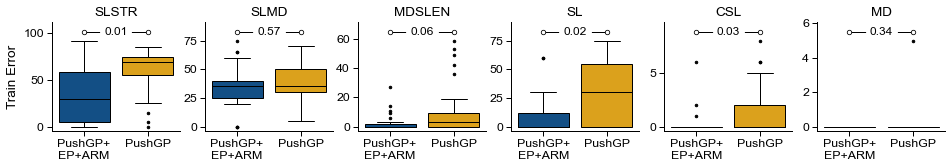

In [9]:
probs_set = [["SLSTR", "SLMD", "MDSLEN", "SL", "CSL", "MD"]]
methods = ["KDPSR", "PushGP"]

for idx, probs in enumerate(probs_set):
    fig, axs = plt.subplots(1, 6, figsize=figsize)
    plt.subplots_adjust(wspace=0.2)
    k = 0
    for ax, prob in zip(axs, probs):
        k += 1
        error_ = error[(error.Problem==prob) & (error.Period=="Train")]
        ax.set_title(prob)
        b = sns.boxplot(data=error_, x="Method", y="Error",
                        order=methods,
                        flierprops=flierprops, boxprops=boxprops,
                        medianprops=medianprops,
                        whiskerprops=whiskerprops, capprops=capprops,
                        saturation=1.,
                        ax=ax)
        h_min, h_max = ax.get_ylim()
        h_total = h_max - h_min
        h_max_ = h_min + h_total*1.15
        ax.set_ylim(h_min, h_max_)
        for i in range(1):
            j = (i+1)%2
            h = h_max+h_total*0.05+i*h_total*0.1
            ax.hlines(y=h, xmin=i, xmax=j, color="black")
            ax.scatter(x=i, y=h, s=20, color="w", edgecolors="black", zorder=2)
            ax.scatter(x=j, y=h, s=20, color="w", edgecolors="black", zorder=2)
            dat1 = error_[error_.Method==methods[i]]["Error"].values
            dat2 = error_[error_.Method==methods[j]]["Error"].values
            _, p = mannwhitneyu(dat1, dat2)
            alpha = 0.05
            alpha = 1 - (1-alpha)**(1/6)
            s = f"{p:.2f}*" if p<alpha else f"{p:.2f}"
            c = "darkred" if p<alpha else "black"
            ax.text((i+j)/2, h, s, color=c, fontsize=annot_size, ha="center", va="center", backgroundcolor="white", zorder=3+3-i)
        ax.set_xlabel("")
        ax.set_ylabel("Train Error")
        if k>1:
            ax.set_ylabel("")
        ax.set_xticklabels(["PushGP+\nEP+ARM", "PushGP"])
        ax.legend([],[],frameon=False)
    plt.savefig(f"figure/train3{idx}.eps", bbox_inches="tight")
    plt.savefig(f"figure/train3{idx}.png", bbox_inches="tight", dpi=300)

## Test success count in 25 runs

- The number above a bar is the success count.
- The value on a line segment is the p-value of **Fisher’s exact test** between two groups.
- The p-value is marked with an asterisk if the difference between two groups is significant (p<0.05).

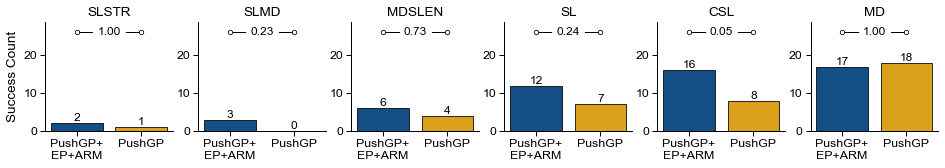

In [10]:
probs_set = [["SLSTR", "SLMD", "MDSLEN", "SL", "CSL", "MD"]]
methods = ["KDPSR", "PushGP"]

for idx, probs in enumerate(probs_set):
    fig, axs = plt.subplots(1, 6, figsize=figsize)
    plt.subplots_adjust(wspace=0.2)
    k = 0
    for ax, prob in zip(axs, probs):
        k += 1
        error_ = error[(error.Problem==prob) & (error.Period=="Test")]
        ax.set_title(prob)
        b = sns.barplot(data=error_, x="Method", y="Success Rate", estimator=sum,
                        order=methods,
                        edgecolor="black",
                        saturation=1.,
                        errcolor="none", ax=ax)
        for container in b.containers:
            b.bar_label(container, fontsize=annot_size)

        stat_ = stat[stat.Problem==prob]
        ax.set_ylim(0, 25)
        h_min, h_max = ax.get_ylim()
        h_total = h_max - h_min
        h_max_ = h_min + h_total*1.15
        ax.set_ylim(h_min, h_max_)
        stat_ = stat[stat.Problem==prob]
        for i in range(1):
            j = (i+1)%2
            h = h_max+h_total*0.05+i*h_total*0.1
            ax.hlines(y=h, xmin=i, xmax=j, color="black")
            ax.scatter(x=i, y=h, s=20, color="w", edgecolors="black", zorder=2)
            ax.scatter(x=j, y=h, s=20, color="w", edgecolors="black", zorder=2)
            try:
                dat1 = stat_[stat_.Method==methods[i]]["Success Rate"].item()
            except Exception:
                dat1 = 0
            try:
                dat2 = stat_[stat_.Method==methods[j]]["Success Rate"].item()
            except Exception:
                dat2 = 0
            x = [[dat1, dat2], [25-dat1, 25-dat2]]
            _, p = fisher_exact(x)
            alpha = 0.05
            alpha = 1 - (1-alpha)**(1/6)
            s = f"{p:.2f}*" if p<alpha else f"{p:.2f}"
            c = "darkred" if p<alpha else "black"
            ax.text((i+j)/2, h, s, color=c, fontsize=annot_size, ha="center", va="center", backgroundcolor="white", zorder=3+3-i)
        ax.set_xlabel("")
        ax.set_ylabel("Success Count")
        if k>1:
            ax.set_ylabel("")
        ax.set_xticklabels(["PushGP+\nEP+ARM", "PushGP"])
        ax.legend([],[],frameon=False)
    plt.savefig(f"figure/count3{idx}.eps", bbox_inches="tight")
    plt.savefig(f"figure/count3{idx}.png", bbox_inches="tight", dpi=300)

## Best train error in the population by generations (avg. of 25 runs）

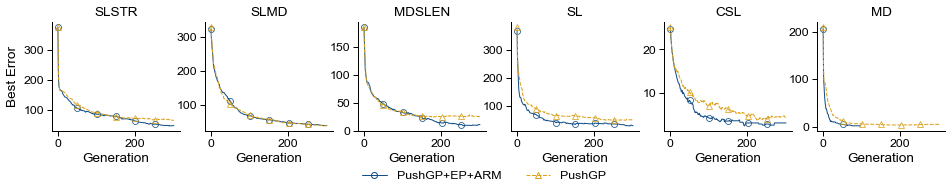

In [11]:
markers = ["o","^","D"]
for idx, probs in enumerate(probs_set):
    fig, axs = plt.subplots(1, 6, figsize=figsize)
    plt.subplots_adjust(wspace=0.2)
    k = 0
    for ax, prob in zip(axs, probs):
        k += 1
        anytime_ = anytime[(anytime.Problem==prob) & (anytime.Method.isin(methods))]
        sns.lineplot(data=anytime_, x="Generation", y="Best Error",
                     hue="Method", hue_order=methods,
                     style="Method", style_order=methods,
                     markers=markers[:2], markevery=50, markersize=6,
                     markerfacecolor="none", markeredgecolor=None,
                     ci=None, ax=ax)
        ax.set_title(prob)
        if k>1:
            ax.set_ylabel("")
        leg = ax.legend(edgecolor="black", shadow=True)
        ax.legend([],[],frameon=False)
    ls = leg.get_lines()
    for line in ls:
        line.set_markersize(6)
        line.set_markeredgecolor(None)
        line.set_markerfacecolor("none")

    fig.legend(ls,
               ["PushGP+EP+ARM", "PushGP"],
               frameon=False,
               loc="lower center", bbox_to_anchor=bbox_to_anchor,
               ncol=3)
    plt.savefig(f"figure/error3{idx}.eps", bbox_inches="tight")
    plt.savefig(f"figure/error3{idx}.png", bbox_inches="tight", dpi=300)